# Cluster Analysis

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [20]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from addutils import css_notebook
from sklearn import metrics
css_notebook()

In [13]:
import bokeh.plotting as bk
from bokeh import palettes
bk.output_notebook()

Loading BokehJS ...

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## 1 Introduction

What is Clustering? *Given a set of data points, partition them into groups (clusters) containing very similar data points.*

This is a rough description of what clustering, for example it does not define what is the **number of clusters**, or what we mean for **similar**. 

Clustering has many applications, for example: data summarization, customer segmentation, social network analysis, preprocessing step for classification or outlier detection.

First of all we will create a synthetic dataset that we will use for each example throughout the notebook.

In [4]:
n_samples = 1500
n_features = 10
random_state = 170
X, _ = make_blobs(n_samples=n_samples, n_features=n_features, 
                  random_state=random_state, centers=4)

In [14]:
pal = palettes.Category10[4]

In [5]:
print(X.shape)

(1500, 10)


In [6]:
tsne = TSNE(n_components=2, random_state=0, perplexity=60)
Y = tsne.fit_transform(X)

In [7]:
print(Y.shape)

(1500, 2)


## 2 KMeans

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:

$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_j - \mu_i||^2)$

Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:
* Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
* Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_pred = kmeans.predict(X)

In [18]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")
fig.scatter(Y[:,0], Y[:,1], fill_color=[pal[i] for i in y_pred], line_color=None)
bk.show(fig)

## 2.1 Silhouette Plot

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 4, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 3.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 2 sub clusters into one big cluster. However when the n_clusters is equal to 3, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

For n_clusters = 3 The average silhouette_score is : 0.660040210029


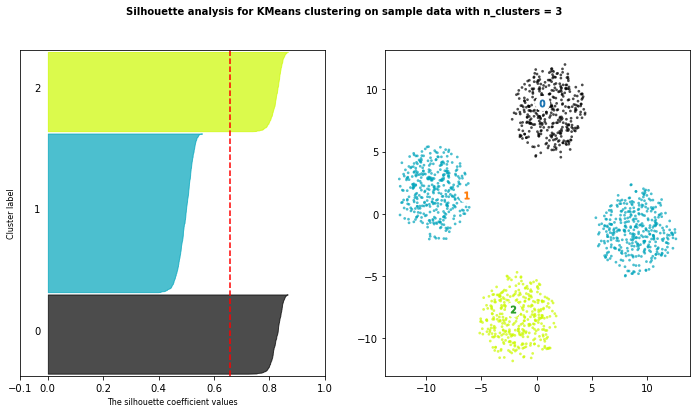

For n_clusters = 4 The average silhouette_score is : 0.79781063526


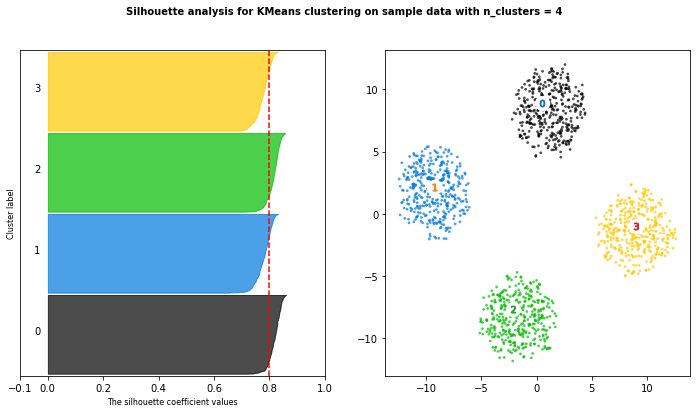

For n_clusters = 5 The average silhouette_score is : 0.625413596162


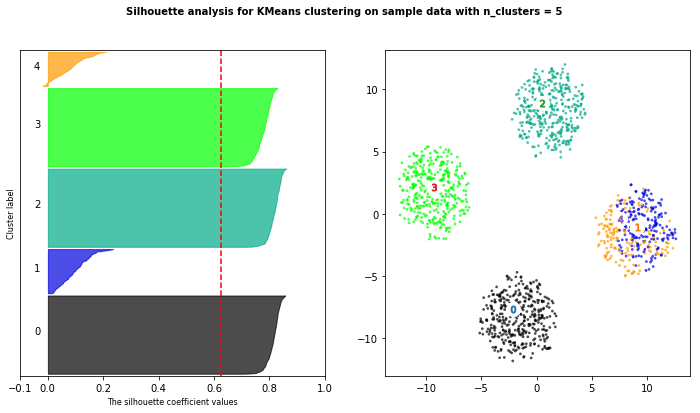

In [48]:
range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.", fontsize=8)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=8)
    ax1.set_ylabel("Cluster label", fontsize=8)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y[:, 0], Y[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    closest, _ = metrics.pairwise_distances_argmin_min(centers, X)
    
    # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1],
    ax2.scatter(Y[closest, 0], Y[closest, 1],
                marker='o', c="white", alpha=1, s=200)

    # for i, c in enumerate(centers):
    # ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
    for i, c in enumerate(closest):
        ax2.scatter(Y[c, 0], Y[c, 1], marker='$%d$' % i, alpha=1, s=50)  

    #ax2.set_title("The visualization of the clustered data.", fontsize=8)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=10, fontweight='bold')
    #fig.tight_layout()
    plt.show()

## 3 DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least eps in distance from any core sample, is considered an outlier by the algorithm.

In the figure below, the color indicates cluster membership, with large circles indicating core samples found by the algorithm. Smaller circles are non-core samples that are still part of a cluster. Moreover, the outliers are indicated by black points below.

In [22]:
metrics.pairwise.pairwise_distances(X).mean()

19.377133063360876

In [23]:
db = DBSCAN(eps=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Silhouette Coefficient: 0.798


In [24]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")
fig.scatter(Y[:,0], Y[:,1], fill_color=[pal[i] for i in y_pred], line_color=None)
bk.show(fig)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.